In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [11]:
import torch

Dataset creation

In [29]:
df = pd.read_parquet(r"C:\Users\Home\Documents\EPFL\ML\Project2\All_Relative_Results_Cleaned.parquet")

In [4]:
df['Camera'].unique()

array(['Frontal_Top', 'Frontal_Low', 'Side_Top'], dtype=object)

In [30]:
df_clean = df.dropna()
index = df_clean.columns.get_loc('time(s)')
df_right = df_clean.iloc[:, index+1:]
X = df_right
Y = df_clean['Exercise']

In [31]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [32]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(Y_encoded, dtype=torch.long)

In [113]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)


In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

train_dataset = TensorDataset(X_train,Y_train)
test_dataset = TensorDataset(X_test,Y_test)
trainLoader = DataLoader(train_dataset, batch_size=151, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=151 , shuffle=True)

**Neural network architecture**

In [116]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64,4096)
        self.layer3 = nn.Linear(4096,512)
        self.layer4 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        return x

model = NeuralNetwork()

**Training configuration**

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Model training**

In [118]:
model.train()

for epoch in range(100):  # 4 is the nbr of epochs
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for inputs, labels in trainLoader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculer la perte moyenne et l'exactitude pour l'époque
    epoch_loss = running_loss / len(trainLoader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Époque {epoch + 1}, Perte: {epoch_loss:.4f}, Exactitude: {epoch_accuracy:.2f}%')


Époque 1, Perte: 0.1671, Exactitude: 92.97%


KeyboardInterrupt: 

**Model testing**

In [28]:
model.eval()  # Mettre le modèle en mode évaluation
total_test = 0
correct_test = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testLoader:
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Exactitude sur l\'ensemble de test: {test_accuracy}%')


Exactitude sur l'ensemble de test: 94.8273097888324%


**Confusion matrix visualization**

Text(52.722222222222214, 0.5, 'True labels')

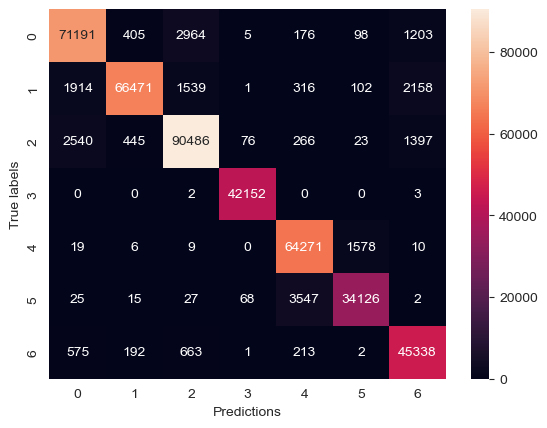

In [29]:
conf_matrix = confusion_matrix(y_true,y_pred)

sns.heatmap(conf_matrix, annot=True, fmt = 'd')
plt.xlabel('Predictions')
plt.ylabel('True labels')

**Classification report**

In [30]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     76042
           1       0.98      0.92      0.95     72501
           2       0.95      0.95      0.95     95233
           3       1.00      1.00      1.00     42157
           4       0.93      0.98      0.95     65893
           5       0.95      0.90      0.93     37810
           6       0.90      0.96      0.93     46984

    accuracy                           0.95    436620
   macro avg       0.95      0.95      0.95    436620
weighted avg       0.95      0.95      0.95    436620


**Convolutionnal Neural network**

Data preprocessing

In [75]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=12672, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

modelCNN = ConvNeuralNetwork()

CNN config

In [76]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(modelCNN.parameters(), lr = 0.0001)

In [77]:
scheduler_cnn = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=30, gamma=0.1)

Training Cnn

In [36]:

cols_x = [col for col in X.columns if col.endswith('x')]
cols_y = [col for col in X.columns if col.endswith('y')]
cols_z = [col for col in X.columns if col.endswith('z')]
tensor_5D = torch.zeros((len(X), 3, 33, 1, 1), dtype=torch.float32)


In [37]:
nbr_of_points = (X.shape[1])//3
X_reshape = X.values.reshape(-1,nbr_of_points,3)
tensor_4D_transposed = np.expand_dims(np.expand_dims(np.transpose(X_reshape, (0, 2, 1)), axis=3), axis=4)
tensor_5D = torch.from_numpy(tensor_4D_transposed)
tensor_5D = tensor_5D.permute(0, 2, 1, 3, 4)
print(tensor_5D.shape)
original_x = X[cols_x[1]].iloc[0]
original_y = X[cols_y[1]].iloc[0]
original_z = X[cols_z[1]].iloc[0]

print( tensor_5D[0, 1,:, 0, 0])
print("Original:", original_x, original_y, original_z)

torch.Size([2183485, 33, 3, 1, 1])
tensor([ 0.0207, -0.6934,  0.0230])
Original: 0.020658314 -0.6934193 0.023042714


In [38]:
data_x = X[cols_x].values
data_y = X[cols_y].values
data_z = X[cols_z].values

# Calculer les moyennes pour chaque axe
mean_x = np.mean(data_x, axis=0)
mean_y = np.mean(data_y, axis=0)
mean_z = np.mean(data_z, axis=0)

# Créer un tableau pour les coordonnées moyennes
mean_coords = np.stack([mean_x, mean_y, mean_z], axis=1)

In [17]:
mean_coords

array([[ 0.11347116,  0.41206405,  0.03817024],
       [-0.04062613, -0.36569685, -0.05145   ],
       [ 0.0444637 , -0.16425118, -0.03951038],
       [-0.05970982, -0.36238524, -0.10778308],
       [-0.05994033, -0.3620406 , -0.10857669],
       [-0.05984277, -0.36266443, -0.10780706],
       [ 0.1345765 ,  0.49102536, -0.01571841],
       [ 0.11900878,  0.4419805 ,  0.04027942],
       [ 0.05345576, -0.00783226,  0.02146522],
       [ 0.08022003, -0.07843729, -0.12882403],
       [ 0.09298596,  0.1810598 , -0.02500963],
       [-0.04554022, -0.32576275, -0.09079313],
       [ 0.08709312, -0.0737981 , -0.11398076],
       [ 0.01826495, -0.27895498, -0.00777375],
       [ 0.07127174, -0.09455614, -0.10589939],
       [ 0.07263917, -0.09979846, -0.09927735],
       [-0.05691947, -0.3361927 , -0.11335   ],
       [ 0.02069723,  0.36627063,  0.02025394],
       [-0.10232808, -0.35418245, -0.08111832],
       [-0.17088765, -0.1485435 , -0.09778771],
       [-0.07242035, -0.35846683, -0.113

In [39]:
from sklearn.decomposition import PCA

# Utiliser PCA pour réduire à trois dimensions
pca = PCA(n_components=3)
reduced_coords = pca.fit_transform(mean_coords)

# Normaliser les coordonnées réduites pour qu'elles correspondent à votre grille 3D
# Par exemple, si votre grille est de taille 3x3x11
normalized_coords = (reduced_coords - reduced_coords.min(0)) / reduced_coords.ptp(0)
print(normalized_coords.shape)
grid_coords = np.round(normalized_coords * np.array([2, 2, 10])).astype(int)


(33, 3)


In [40]:
unique_coords, counts = np.unique(grid_coords, axis=0, return_counts=True)

# Identifier les coordonnées où plus d'une feature a été mappée
duplicate_coords = unique_coords[counts > 1]
print("Coordonnées avec des doublons :", duplicate_coords)

Coordonnées avec des doublons : [[0 1 3]
 [0 1 4]
 [1 0 8]
 [1 2 5]
 [2 1 1]]


In [41]:
duplicate_coords.shape

(5, 3)

In [42]:
for coord in duplicate_coords:
    # Trouver les indices des features qui ont été mappées à ces coordonnées
    features_at_coord = np.where((grid_coords == coord).all(axis=1))[0]
    print(f"Features mappées à {coord} : {features_at_coord}")


Features mappées à [0 1 3] : [11 28]
Features mappées à [0 1 4] : [ 3  4  5 16 20 21 22]
Features mappées à [1 0 8] : [14 15]
Features mappées à [1 2 5] : [31 32]
Features mappées à [2 1 1] : [17 24]


In [43]:
feature_to_grid = {}
for feature_idx, coord in enumerate(grid_coords):
    coord_tuple = tuple(coord)
    if coord_tuple not in feature_to_grid:
        feature_to_grid[coord_tuple] = []
    feature_to_grid[coord_tuple].append(feature_idx)

# Identifier les coordonnées avec des doublons
for coord, features in feature_to_grid.items():
    if len(features) > 1:
        print(f"Coordonnées {coord} ont les features {features}")


Coordonnées (0, 1, 4) ont les features [3, 4, 5, 16, 20, 21, 22]
Coordonnées (0, 1, 3) ont les features [11, 28]
Coordonnées (1, 0, 8) ont les features [14, 15]
Coordonnées (2, 1, 1) ont les features [17, 24]
Coordonnées (1, 2, 5) ont les features [31, 32]


In [23]:
mean_coords

array([[ 0.11347116,  0.41206405,  0.03817024],
       [-0.04062613, -0.36569685, -0.05145   ],
       [ 0.0444637 , -0.16425118, -0.03951038],
       [-0.05970982, -0.36238524, -0.10778308],
       [-0.05994033, -0.3620406 , -0.10857669],
       [-0.05984277, -0.36266443, -0.10780706],
       [ 0.1345765 ,  0.49102536, -0.01571841],
       [ 0.11900878,  0.4419805 ,  0.04027942],
       [ 0.05345576, -0.00783226,  0.02146522],
       [ 0.08022003, -0.07843729, -0.12882403],
       [ 0.09298596,  0.1810598 , -0.02500963],
       [-0.04554022, -0.32576275, -0.09079313],
       [ 0.08709312, -0.0737981 , -0.11398076],
       [ 0.01826495, -0.27895498, -0.00777375],
       [ 0.07127174, -0.09455614, -0.10589939],
       [ 0.07263917, -0.09979846, -0.09927735],
       [-0.05691947, -0.3361927 , -0.11335   ],
       [ 0.02069723,  0.36627063,  0.02025394],
       [-0.10232808, -0.35418245, -0.08111832],
       [-0.17088765, -0.1485435 , -0.09778771],
       [-0.07242035, -0.35846683, -0.113

In [24]:
X[cols_x].mean(axis = 0)

left_ankle_x          0.113471
left_ear_x           -0.040626
left_elbow_x          0.044464
left_eye_center_x    -0.059710
left_eye_inner_x     -0.059940
left_eye_outer_x     -0.059843
left_foot_x           0.134576
left_heel_x           0.119009
left_hip_x            0.053456
left_index_x          0.080220
left_knee_x           0.092986
left_mouth_x         -0.045540
left_pinky_x          0.087093
left_shoulder_x       0.018265
left_thumb_x          0.071272
left_wrist_x          0.072639
nose_x               -0.056919
right_ankle_x         0.020697
right_ear_x          -0.102328
right_elbow_x        -0.170888
right_eye_center_x   -0.072420
right_eye_inner_x    -0.072615
right_eye_outer_x    -0.072744
right_foot_x          0.027155
right_heel_x          0.023316
right_hip_x          -0.053625
right_index_x        -0.163527
right_knee_x         -0.006597
right_mouth_x        -0.063512
right_pinky_x        -0.176237
right_shoulder_x     -0.126894
right_thumb_x        -0.171385
right_wr

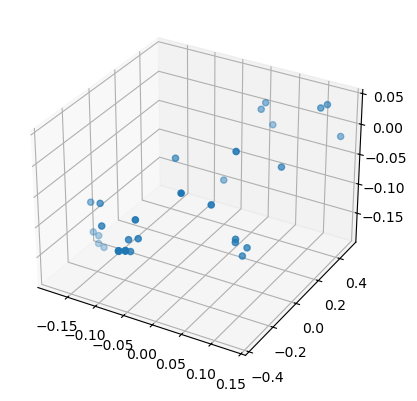

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mean_coords[:,0], mean_coords[:,1], mean_coords[:,2])
plt.show()

In [46]:
depth, height, width = 3, 3, 11

# Nombre de canaux (supposons 3 pour x, y, z)
num_channels = 3

# Nombre d'échantillons
num_samples = 2183485

# Initialiser un tenseur vide
grid_tensor = torch.zeros((num_samples, num_channels, depth, height, width))

In [47]:
# Parcourir chaque feature et placer ses valeurs dans le tenseur
for feature_idx in range(33):  # Supposons que vous avez 33 features
    # Coordonnées normalisées et arrondies pour la feature actuelle
    d, h, w = grid_coords[feature_idx]

    # Assurer que les indices sont dans les limites de la grille
    d, h, w = np.clip([d, h, w], 0, [depth - 1, height - 1, width - 1])

    # Placer les valeurs de la feature dans le tenseur
    # Ici, cols_x, cols_y, cols_z sont les noms des colonnes dans X pour chaque coordonnée
    grid_tensor[:, 0, d, h, w] = torch.tensor(X[cols_x[feature_idx]].values)
    grid_tensor[:, 1, d, h, w] = torch.tensor(X[cols_y[feature_idx]].values)
    grid_tensor[:, 2, d, h, w] = torch.tensor(X[cols_z[feature_idx]].values)


In [48]:
for feature_idx in range(5):  # Vérifier les 5 premières features
    d, h, w = grid_coords[feature_idx]
    print(f"Feature {feature_idx}: Coordonnées dans la grille - Profondeur: {d}, Hauteur: {h}, Largeur: {w}")

sample_idx = 0  # Index d'un échantillon
d, h, w = 1, 1, 4  # Choisissez une position spécifique dans la grille
print(grid_tensor[sample_idx, :, d, h, w])  # Affiche les valeurs x, y, z à cette position


Feature 0: Coordonnées dans la grille - Profondeur: 2, Hauteur: 0, Largeur: 2
Feature 1: Coordonnées dans la grille - Profondeur: 0, Hauteur: 0, Largeur: 1
Feature 2: Coordonnées dans la grille - Profondeur: 1, Hauteur: 0, Largeur: 3
Feature 3: Coordonnées dans la grille - Profondeur: 0, Hauteur: 1, Largeur: 4
Feature 4: Coordonnées dans la grille - Profondeur: 0, Hauteur: 1, Largeur: 4
tensor([0., 0., 0.])


In [49]:
print(grid_coords.shape)

(33, 3)


In [50]:
# Coordonnées normalisées et arrondies pour la première feature
d, h, w = grid_coords[0]
print(f"Coordonnées normalisées et arrondies de la première feature : Profondeur: {d}, Hauteur: {h}, Largeur: {w}")


Coordonnées normalisées et arrondies de la première feature : Profondeur: 2, Hauteur: 0, Largeur: 2


In [51]:
# Assurez-vous que les indices sont dans les limites de la grille
d, h, w = np.clip([d, h, w], 0, [depth - 1, height - 1, width - 1])

# Récupérer les valeurs de la première feature dans le tenseur
feature_values = grid_tensor[:, :, d, h, w]
print(f"Valeurs de la première feature dans le tenseur : {feature_values}")
print(feature_values.shape)

Valeurs de la première feature dans le tenseur : tensor([[0.0093, 0.7793, 0.1879],
        [0.0094, 0.7793, 0.1851],
        [0.0097, 0.7793, 0.1792],
        ...,
        [0.1054, 0.7652, 0.0840],
        [0.1064, 0.7653, 0.0840],
        [0.1070, 0.7653, 0.0835]])
torch.Size([2183485, 3])


In [52]:
# Valeurs originales de la première feature dans X
original_values = X.iloc[:, :3]  # Supposant que les 3 premières colonnes sont x, y, z de la première feature
print(f"Valeurs originales de la première feature dans X : {original_values.head()}")


Valeurs originales de la première feature dans X :    left_ankle_x  left_ankle_y  left_ankle_z
0      0.009328      0.779305      0.187880
1      0.009353      0.779298      0.185050
2      0.009722      0.779311      0.179212
3      0.011696      0.778027      0.166566
4      0.011671      0.778045      0.166878


In [53]:
grid_tensor.shape 

torch.Size([2183485, 3, 3, 3, 11])

In [79]:
Y_tensor_cnn = y_tensor
X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(grid_tensor, Y_tensor_cnn, test_size=0.8)

print(X_train_cnn.shape)
dataset_train_cnn = TensorDataset(X_train_cnn, Y_train_cnn)
trainLoader_cnn = DataLoader(dataset_train_cnn, batch_size=33, shuffle=True)
dataset_test_cnn = TensorDataset(X_test_cnn, Y_test_cnn)
testLoader_cnn = DataLoader(dataset_test_cnn, batch_size=32, shuffle=True)

torch.Size([436697, 3, 3, 3, 11])


In [80]:
num_epochs = 100  # ou le nombre d'époques souhaité
modelCNN.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for inputs, labels in trainLoader_cnn:
        optimizer_cnn.zero_grad()   
        outputs = modelCNN(inputs)  
        loss = criterion_cnn(outputs, labels)  
        loss.backward()                    
        optimizer_cnn.step()
        _, predicted = torch.max(outputs.data, 1)
        running_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        #if scheduler_cnn:
            #scheduler_cnn.step()
    epoch_accuracy = 100 * correct_train / total_train
    print(f"Epuch {epoch + 1}/{num_epochs}, Loss : {running_loss / len(trainLoader_cnn)},  Accuracy: {epoch_accuracy:.2f}%'")


Epuch 1/100, Loss : 0.262394344047651,  Accuracy: 90.10%'
Epuch 2/100, Loss : 0.18831119134112798,  Accuracy: 92.25%'
Epuch 3/100, Loss : 0.17016363440175636,  Accuracy: 92.90%'
Epuch 4/100, Loss : 0.15966599419216904,  Accuracy: 93.35%'
Epuch 5/100, Loss : 0.15226581927553456,  Accuracy: 93.60%'
Epuch 6/100, Loss : 0.14628141976998896,  Accuracy: 93.87%'
Epuch 7/100, Loss : 0.1414830046712796,  Accuracy: 94.02%'
Epuch 8/100, Loss : 0.1375865141478428,  Accuracy: 94.18%'
Epuch 9/100, Loss : 0.13394925167211175,  Accuracy: 94.35%'
Epuch 10/100, Loss : 0.13061814200022243,  Accuracy: 94.48%'
Epuch 11/100, Loss : 0.12791332077928616,  Accuracy: 94.61%'
Epuch 12/100, Loss : 0.125158974011237,  Accuracy: 94.71%'
Epuch 13/100, Loss : 0.12268757551584653,  Accuracy: 94.81%'
Epuch 14/100, Loss : 0.12055254856722708,  Accuracy: 94.92%'
Epuch 15/100, Loss : 0.11824885043884999,  Accuracy: 94.99%'
Epuch 16/100, Loss : 0.11596279844730838,  Accuracy: 95.12%'
Epuch 17/100, Loss : 0.1139915125692847

In [83]:
modelCNN.eval()  
total_test = 0
correct_test = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testLoader_cnn:
        labels = labels.long()
        outputs = modelCNN(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test accuracy: {test_accuracy}%')

Test accuracy: 97.32217074997081%


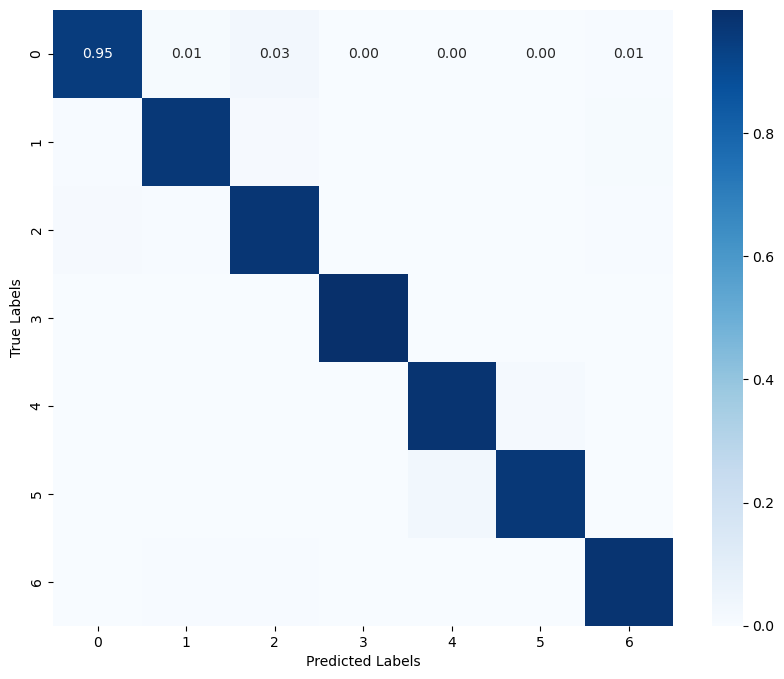

In [108]:
conf_matrix = confusion_matrix(y_true,y_pred)

normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(normalized_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [90]:
from collections import Counter

# Compter les occurrences de chaque label dans y_true
label_counts = Counter(y_true)
print(label_counts)


Counter({2: 381826, 0: 304493, 1: 289648, 4: 262451, 6: 187588, 3: 169812, 5: 150970})


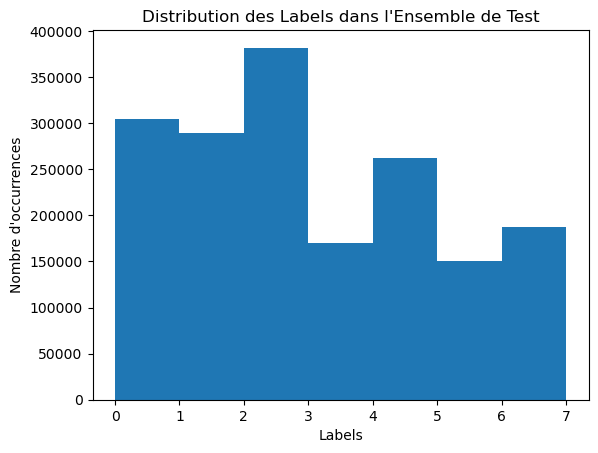

In [91]:
import matplotlib.pyplot as plt

# Histogramme des labels
plt.hist(y_true, bins=range(min(y_true), max(y_true) + 2))
plt.xlabel('Labels')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des Labels dans l\'Ensemble de Test')
plt.show()


In [102]:
print(conf_matrix)

[[290143   3481   8841      0    147    105   1776]
 [  2104 280236   4459      0    135    185   2529]
 [  4547   2664 371462     21    123     96   2913]
 [     0      1      9 169785      0     17      0]
 [    18      9     11      0 257719   4663     31]
 [    14     19      4      0   4738 146170     25]
 [   604   1455    954      0     74      4 184497]]


In [85]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96    304493
           1       0.97      0.97      0.97    289648
           2       0.96      0.97      0.97    381826
           3       1.00      1.00      1.00    169812
           4       0.98      0.98      0.98    262451
           5       0.97      0.97      0.97    150970
           6       0.96      0.98      0.97    187588

    accuracy                           0.97   1746788
   macro avg       0.97      0.98      0.97   1746788
weighted avg       0.97      0.97      0.97   1746788


C:\Users\Home\.conda\envs\ADA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Home\.conda\envs\ADA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Home\.conda\envs\ADA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Home\.conda\envs\ADA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

Text(0, 0.5, '')

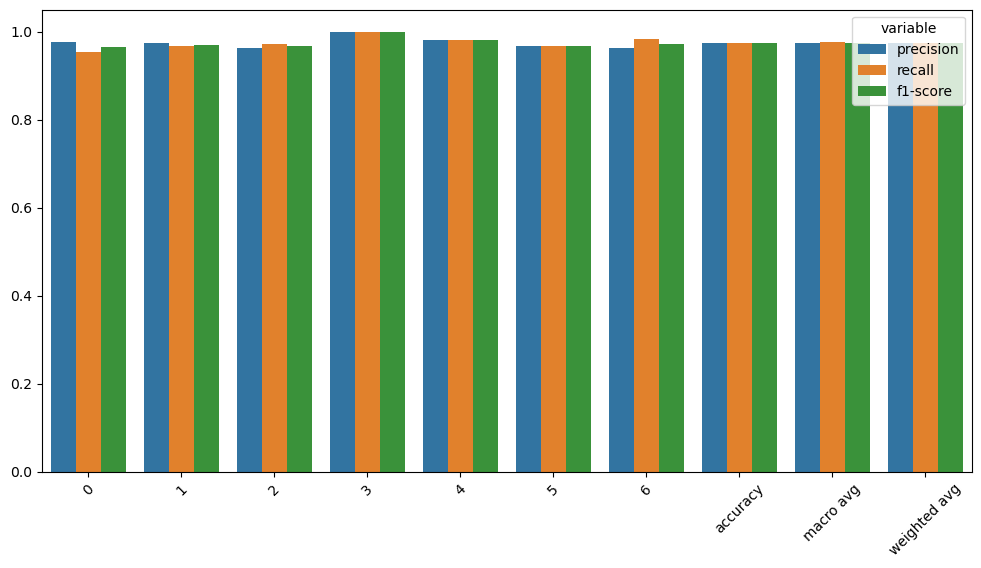

In [99]:
# Melt le DataFrame pour la visualisation
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Supprimer la ligne de support pour une meilleure visualisation
df_report = df_report.drop('support', axis=1)
df_melt = df_report.reset_index().melt(id_vars='index')

# Créer un barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='value', hue='variable', data=df_melt)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')


In [6]:
def map_to_grid(x, y, z, grid_size, min_vals, max_vals):
    x_norm = (x - min_vals[0]) / (max_vals[0] - min_vals[0])
    y_norm = (y - min_vals[1]) / (max_vals[1] - min_vals[1])
    z_norm = (z - min_vals[2]) / (max_vals[2] - min_vals[2])

    x_idx = np.clip((x_norm * grid_size).astype(int), 0, grid_size - 1)
    y_idx = np.clip((y_norm * grid_size).astype(int), 0, grid_size - 1)
    z_idx = np.clip((z_norm * grid_size).astype(int), 0, grid_size - 1)


    return x_idx, y_idx, z_idx


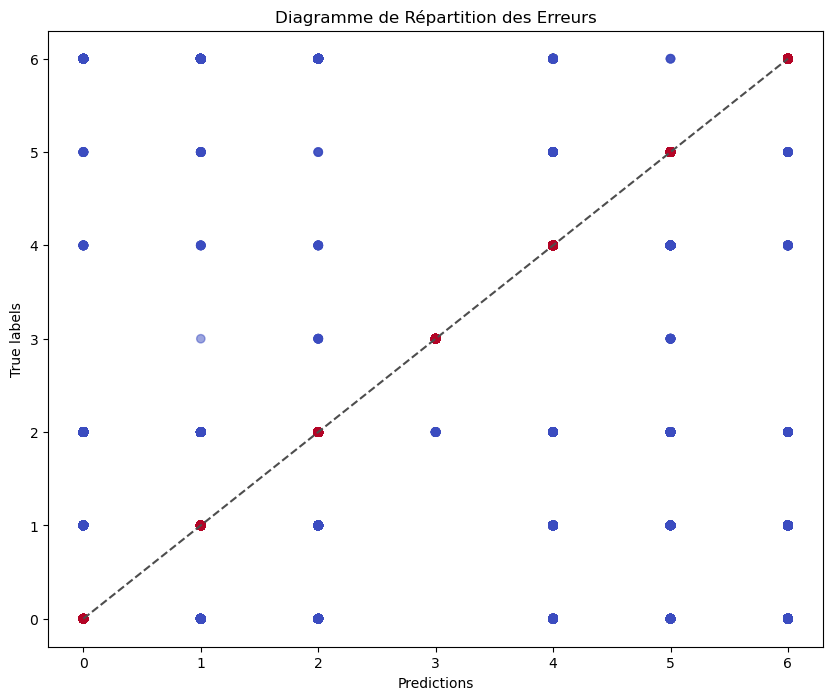

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# y_true et y_pred sont vos listes de vraies étiquettes et d'étiquettes prédites
y_true = np.array(y_true)
y_pred = np.array(y_pred)

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, y_true, alpha=0.5, c=(y_pred == y_true), cmap='coolwarm')  # Les prédictions correctes sont colorées différemment
plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.title('Diagramme de Répartition des Erreurs')
plt.xticks(range(len(np.unique(y_true))))  # Ajustez selon le nombre de classes
plt.yticks(range(len(np.unique(y_true))))  # Ajustez selon le nombre de classes
plt.plot(range(len(np.unique(y_true))), range(len(np.unique(y_true))), ls="--", c=".3")  # Ligne diagonale
plt.show()
